# **Song recommendation algorithm**

Personalized music recommendation system using the Alternating Least Squares (ALS) algorithm.

In [5]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import implicit
from scipy.sparse import csr_matrix
from tempfile import TemporaryDirectory
import kagglehub
from kagglehub import KaggleDatasetAdapter

/home/mbog/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def load_data(path):
    return kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "solomonameh/spotify-music-dataset",
        path,
    )

In [7]:
def load_spotify_data():
    high_popularity = load_data("high_popularity_spotify_data.csv")
    low_popularity = load_data("low_popularity_spotify_data.csv")
    
    # Add a popularity category label to datasets
    high_popularity['popularity_category'] = 'high'
    low_popularity['popularity_category'] = 'low'
    
    # Combine the datasets
    combined_data = pd.concat([high_popularity, low_popularity], ignore_index=True)
    
    print(f"Total songs in dataset: {len(combined_data)}")
    print(f"High popularity songs: {len(high_popularity)}")
    print(f"Low popularity songs: {len(low_popularity)}")
    
    return combined_data

spotify_data = load_spotify_data()
spotify_data.head()

/tmp/ipykernel_110948/219233014.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  return kagglehub.load_dataset(
/tmp/ipykernel_110948/219233014.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  return kagglehub.load_dataset(


Total songs in dataset: 4831
High popularity songs: 1686
Low popularity songs: 3145


,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,...,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id,popularity_category
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3.0,0.0304,...,10FLjwfpbxLmW8c25Xyc2N,0.0,6.0,251668.0,0.3080,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4.0,0.0358,...,7aJuG4TFXa2hmE4z1yxc3n,1.0,2.0,210373.0,0.2000,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4.0,0.0368,...,0hBRqPYPXhr1RkTDG3n4Mk,1.0,1.0,166300.0,0.2140,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,Sabrina Carpenter,4.0,0.0634,...,4B4Elma4nNDUyl6D5PvQkj,0.0,0.0,157280.0,0.0939,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4.0,0.2600,...,2IYQwwgxgOIn7t3iF6ufFD,0.0,0.0,169917.0,0.0283,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high


In [8]:
def explore_data(data):
    print("Dataset shape:", data.shape)
    print("\nData types:")
    print(data.dtypes)
    
    # Check for missing values
    print("\nMissing values:")
    missing_values = data.isnull().sum()
    print(missing_values[missing_values > 0])  # Only show columns with missing values
    
    # Identify numerical and categorical features
    numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_features = data.select_dtypes(include=['object']).columns.tolist()
    
    print(f"\nNumerical features ({len(numerical_features)}):", numerical_features[:10], "...")
    print(f"\nCategorical features ({len(categorical_features)}):", categorical_features)
    
    # Display summary statistics for key audio features
    audio_features = ['energy', 'danceability', 'acousticness', 'valence', 
                      'tempo', 'loudness', 'liveness', 'speechiness', 
                      'instrumentalness', 'track_popularity']
    
    print("\nSummary statistics for key audio features:")
    print(data[audio_features].describe())
    
    # Display genre distribution
    print("\nGenre distribution:")
    print(data['playlist_genre'].value_counts())
    
    return numerical_features, categorical_features, audio_features

numerical_features, categorical_features, audio_features = explore_data(spotify_data)

Dataset shape: (4831, 30)

Data types:
energy                      float64
tempo                       float64
danceability                float64
playlist_genre               object
loudness                    float64
liveness                    float64
valence                     float64
track_artist                 object
time_signature              float64
speechiness                 float64
track_popularity              int64
track_href                   object
uri                          object
track_album_name             object
playlist_name                object
analysis_url                 object
track_id                     object
track_name                   object
track_album_release_date     object
instrumentalness            float64
track_album_id               object
mode                        float64
key                         float64
duration_ms                 float64
acousticness                float64
id                           object
playlist_subgenre        

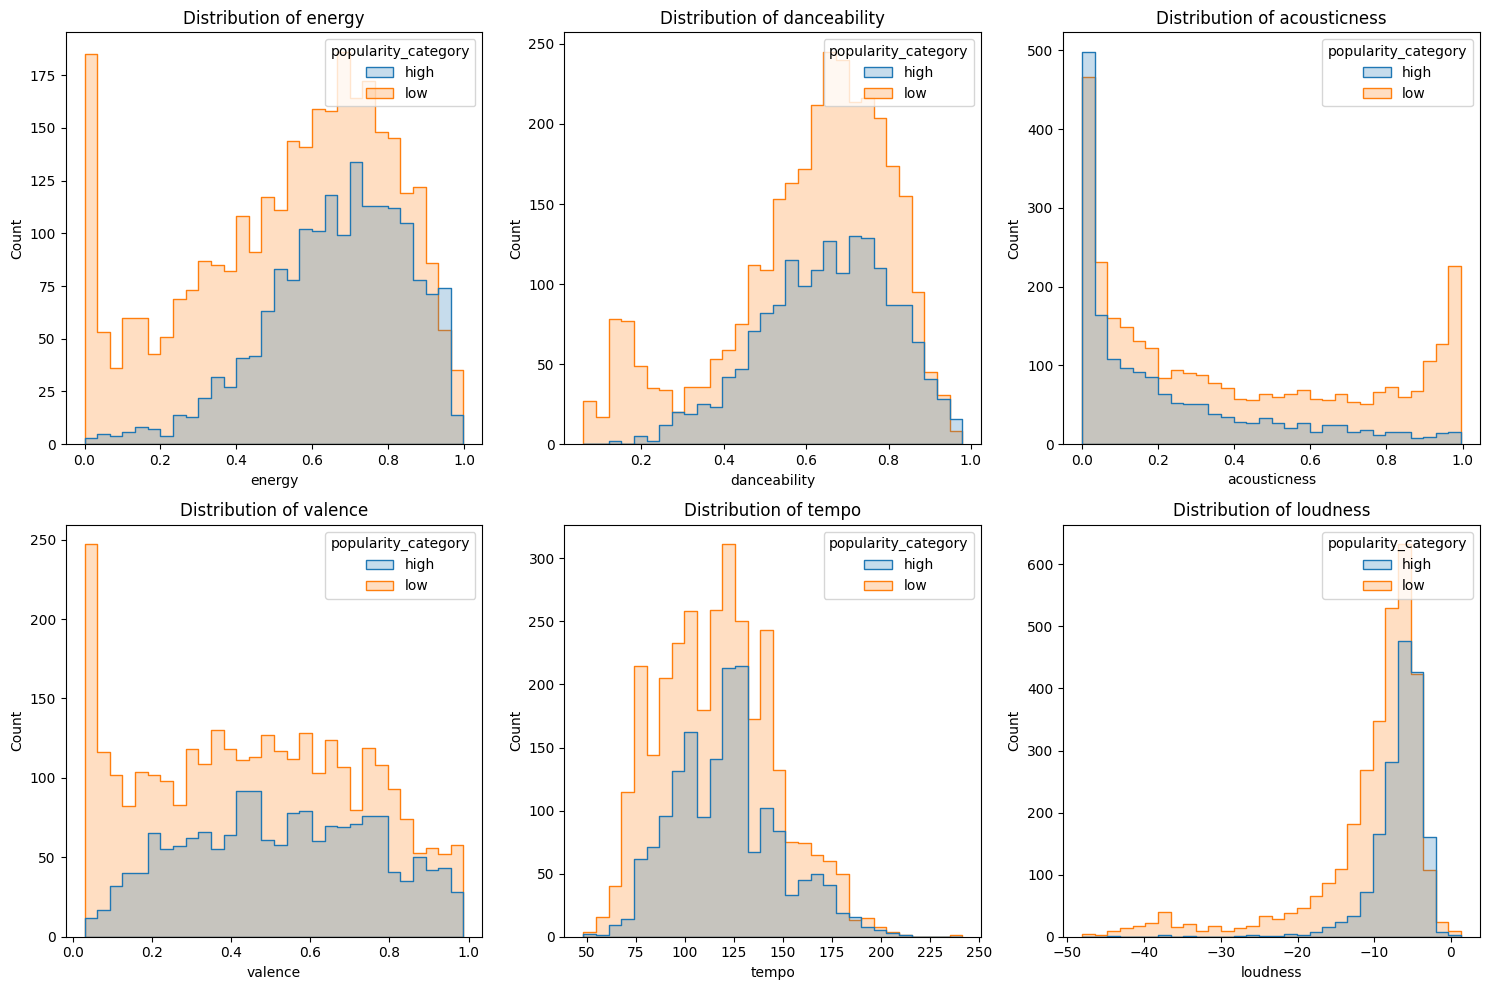

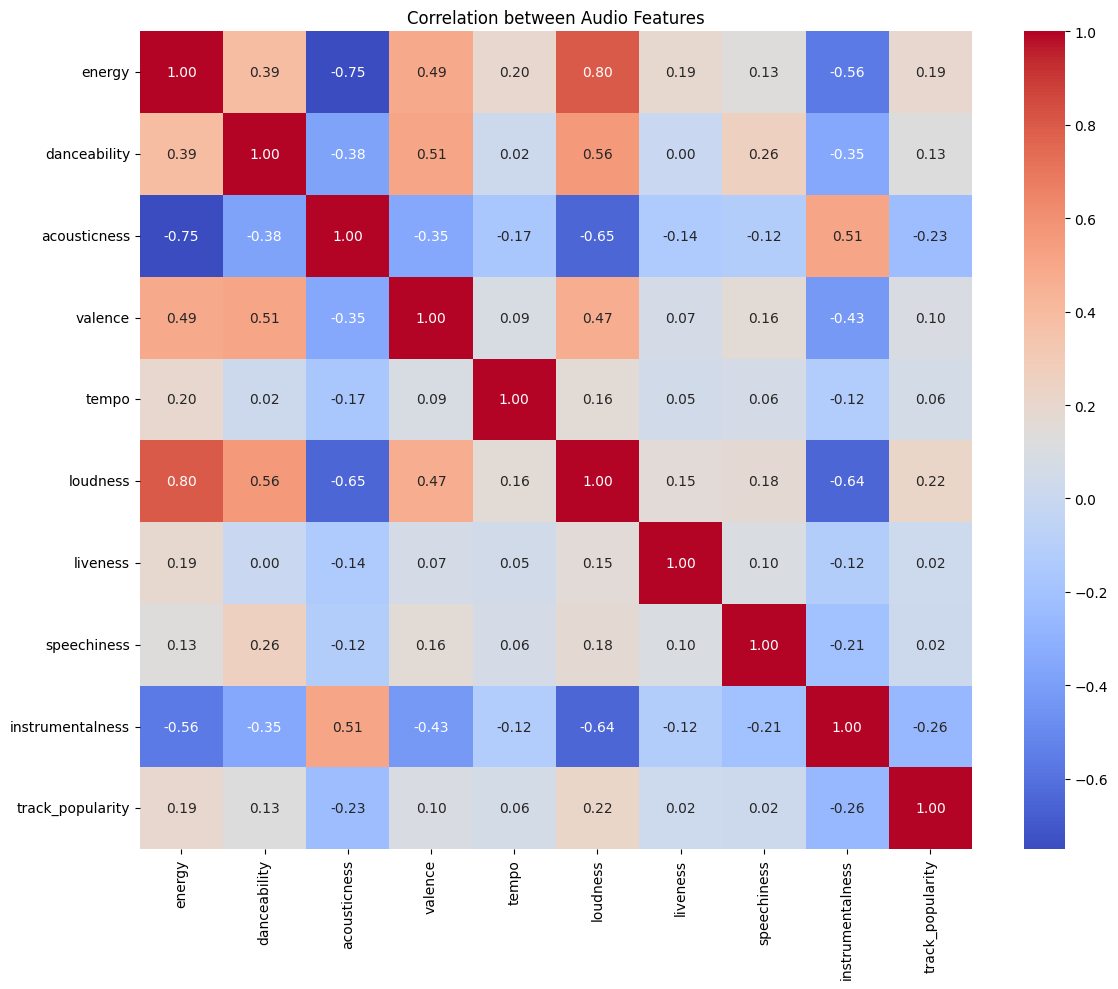

In [9]:
def visualize_features(data, audio_features):
    plt.figure(figsize=(15, 10))
    
    features_to_plot = ['energy', 'danceability', 'acousticness', 'valence', 'tempo', 'loudness']
    
    for i, feature in enumerate(features_to_plot, 1):
        plt.subplot(2, 3, i)
        sns.histplot(data=data, x=feature, hue='popularity_category', element='step', bins=30)
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Create correlation heatmap
    plt.figure(figsize=(12, 10))
    correlation = data[audio_features].corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation between Audio Features')
    plt.tight_layout()
    plt.show()

visualize_features(spotify_data, audio_features)

In [ ]:
# Prepare data for ALS by creating interaction matrices
def prepare_data_for_als(spotify_data):
    print("Preparing data for ALS model...")
    
    spotify_data = spotify_data.copy()
    
    # Ensure track_id is unique
    spotify_data['unique_id'] = spotify_data['track_id']

    # If there are duplicate track_ids, make them unique
    if spotify_data['unique_id'].duplicated().any():
        print("Found duplicate track_ids, creating unique identifiers...")
        spotify_data['unique_id'] = spotify_data['track_id'] + '_' + spotify_data.index.astype(str)
    
    # Create a mapping from track_id to index
    track_to_idx = {tid: i for i, tid in enumerate(spotify_data['unique_id'].unique())}
    idx_to_track = {i: tid for tid, i in track_to_idx.items()}
    
    # Number of tracks
    n_tracks = len(track_to_idx)
    print(f"Total number of unique tracks: {n_tracks}")
    
    
    # Normalize audio features for similarity calculation
    features_for_sim = ['energy', 'danceability', 'acousticness',  'valence',
                        'instrumentalness', 'loudness', 'liveness', 'speechiness']
    
    # Create a scaler
    scaler = MinMaxScaler()
    spotify_data[features_for_sim] = spotify_data[features_for_sim].fillna(0)
    spotify_data[features_for_sim] = scaler.fit_transform(spotify_data[features_for_sim])
    
    # Encode playlist_genre
    genre_encoder = LabelEncoder()
    spotify_data['genre_encoded'] = genre_encoder.fit_transform(spotify_data['playlist_genre'])
    
    # Encode artists
    artist_encoder = LabelEncoder()
    spotify_data['artist_encoded'] = artist_encoder.fit_transform(spotify_data['track_artist'])
    
    # Create feature vectors for each track
    feature_vectors = spotify_data[features_for_sim].values
    
    # Add track popularity as a weight factor (normalized to 0-1)
    max_popularity = spotify_data['track_popularity'].max()
    spotify_data['popularity_weight'] = spotify_data['track_popularity'] / max_popularity
    
    # Build sparse matrix for ALS
    
    from sklearn.neighbors import NearestNeighbors
    k_neighbors = min(20, n_tracks - 1)  # Get top k similar tracks for each track
    
    print(f"Computing {k_neighbors} nearest neighbors for each track...")
    
    # Create nearest neighbor model
    nn_model = NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto', metric='cosine')
    nn_model.fit(feature_vectors)
    
    # Find k nearest neighbors for each track
    distances, indices = nn_model.kneighbors(feature_vectors)
    
    # Convert distances to similarities (1 - distance) for cosine similarity
    similarities = 1 - distances
    
    # Prepare data for sparse matrix (each row: track_idx, similar_track_idx, similarity_score)
    rows = []
    cols = []
    data = []
    
    # Convert track indices to original indices in our dataframe
    track_indices = np.arange(len(spotify_data))
    
    # For each track, add its similar tracks to the interaction matrix
    for i, track_idx in enumerate(track_indices):
        track_id_idx = track_to_idx[spotify_data.iloc[track_idx]['unique_id']]
        
        # Add interactions with similar tracks
        for j, sim_track_rel_idx in enumerate(indices[i]):
            # Get the index in the original dataframe
            sim_track_idx = track_indices[sim_track_rel_idx]
            sim_track_id_idx = track_to_idx[spotify_data.iloc[sim_track_idx]['unique_id']]
            
            # Skip self-interactions
            if track_id_idx == sim_track_id_idx:
                continue
                
            # Calculate interaction strength based on similarity and popularity
            # Weight by popularity of the similar track
            interaction_strength = (similarities[i, j] * 
                                   spotify_data.iloc[sim_track_idx]['popularity_weight'])
            
            # Only include if the interaction strength is significant
            if interaction_strength > 0.1:  # Threshold to keep matrix sparse
                rows.append(track_id_idx)
                cols.append(sim_track_id_idx)
                data.append(float(interaction_strength))
    
    # Create sparse matrix for ALS
    interaction_matrix = csr_matrix((data, (rows, cols)), shape=(n_tracks, n_tracks))
    
    print(f"Created interaction matrix with {len(data)} non-zero entries")
    print(f"Matrix density: {len(data) / (n_tracks * n_tracks):.6f}")
    
    return interaction_matrix, track_to_idx, idx_to_track, spotify_data

interaction_matrix, track_to_idx, idx_to_track, spotify_data_processed = prepare_data_for_als(spotify_data)

Preparing data for ALS model...
Found duplicate track_ids, creating unique identifiers...
Total number of unique tracks: 4831
Computing 20 nearest neighbors for each track...
Created interaction matrix with 91789 non-zero entries
Matrix density: 0.003933


In [ ]:
# Train an ALS model
def train_als_model(interaction_matrix, factors=100, regularization=0.01, iterations=15):
    print(f"Training ALS model with {factors} factors...")
    
    # Initialize the ALS model
    model = implicit.als.AlternatingLeastSquares(
        factors=factors,
        regularization=regularization,
        iterations=iterations,
        calculate_training_loss=True,
        random_state=42
    )
    
    # Fit the model
    model.fit(interaction_matrix, show_progress=True)
    
    return model

als_model = train_als_model(interaction_matrix)

Training ALS model with 100 factors...


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 20.45it/s, loss=0.00164]


In [34]:
# Evaluate ALS model performance
def evaluate_als_model(model, interaction_matrix, k=10):
    from implicit.evaluation import precision_at_k, mean_average_precision_at_k
    
    train, test = implicit.evaluation.train_test_split(interaction_matrix, train_percentage=0.8, random_state=42)
    
    # precision at k
    p_at_k = precision_at_k(model, train, test, K=k, show_progress=True)
    
    # mean average precision at k
    map_at_k = mean_average_precision_at_k(model, train, test, K=k, show_progress=True)
    
    print(f"Precision@{k}: {p_at_k:.4f}")
    print(f"MAP@{k}: {map_at_k:.4f}")
    
    return p_at_k, map_at_k

precision, mean_ap = evaluate_als_model(als_model, interaction_matrix)

  0%|          | 0/4765 [00:00<?, ?it/s]

100%|██████████| 4765/4765 [00:01<00:00, 4559.02it/s]

Precision@10: 0.3899
MAP@10: 0.2340


In [36]:
# Function to generate song recommendations based on user favorites
def recommend_songs(model, user_favorites, all_songs, track_to_idx, idx_to_track, top_n=10):
    
    # Check if all required audio features are present in all_songs
    required_features = ['energy', 'danceability', 'acousticness', 'valence', 'tempo']
    missing_features = [f for f in required_features if f not in all_songs.columns]
    if missing_features:
        print(f"Warning: Missing required audio features: {missing_features}")
        print(f"Available columns: {all_songs.columns.tolist()[:10]}...")

    # Get user favorite songs
    favorite_songs = all_songs[all_songs['track_id'].isin(user_favorites)].copy()
    
    if len(favorite_songs) == 0:
        print("No favorite songs found in the dataset")
        return pd.DataFrame()
    
    print(f"Found {len(favorite_songs)} favorite songs")
    
    # Get indices of favorite songs in our matrix
    favorite_indices = []
    for _, row in favorite_songs.iterrows():
        track_id = row['unique_id']
        if track_id in track_to_idx:
            favorite_indices.append(track_to_idx[track_id])
    
    if not favorite_indices:
        print("Could not find any favorite songs in the model data")
        return pd.DataFrame()
    
    # Get the user factors for favorite songs (average them to create a user profile)
    user_factors = model.item_factors[favorite_indices].mean(axis=0)
    
    # Calculate scores for all songs
    scores = model.item_factors.dot(user_factors)
    
    # Get indices of top N recommendations (excluding favorites)
    all_indices = np.arange(len(scores))
    mask = np.ones(len(scores), dtype=bool)
    mask[favorite_indices] = False
    valid_indices = all_indices[mask]
    
    # Sort valid indices by score
    top_indices = valid_indices[np.argsort(-scores[valid_indices])][:top_n]
    
    # Get track IDs for recommendations
    recommended_track_ids = [idx_to_track[idx].split('_')[0] for idx in top_indices]  # Get original track_id
    
    # Get recommendation data from the dataframe
    recommendations = all_songs[all_songs['track_id'].isin(recommended_track_ids)].copy()
    
    # Add recommendation scores
    recommendations['recommendation_score'] = [scores[idx] for idx in top_indices]
    
    # Sort by recommendation score
    recommendations = recommendations.sort_values('recommendation_score', ascending=False)
    
    result_columns = ['track_name', 'track_artist', 'track_album_name', 'playlist_genre', 
                     'energy', 'danceability', 'valence', 'tempo', 'acousticness',
                     'instrumentalness', 'loudness', 'liveness', 'speechiness',
                     'recommendation_score']
    
    return recommendations[result_columns]

In [ ]:
def example_recommendation():
    sample_favorites = spotify_data.sample(5)
    user_favorite_track_ids = sample_favorites['track_id'].tolist()
    
    print("User's favorite songs:")
    display_cols = ['track_name', 'track_artist', 'playlist_genre']
    print(spotify_data[spotify_data['track_id'].isin(user_favorite_track_ids)][display_cols])
    
    # Get recommendations
    recommendations = recommend_songs(
        als_model, user_favorite_track_ids, spotify_data_processed, 
        track_to_idx, idx_to_track, top_n=10
    )
    
    print("\nRecommended songs:")
    print(recommendations[['track_name', 'track_artist', 'playlist_genre', 'recommendation_score']])
    
    return recommendations, user_favorite_track_ids

example_recommendations, example_favorites = example_recommendation()

User's favorite songs:
                                            track_name  \
1733  Piano Concerto in One Movement: Adagio cantabile   
2009                                           horizon   
2200                                               777   
2829                                   Can You Feel It   
4588                                        Near Light   

                                           track_artist playlist_genre  
1733  Florence Beatrice Price, Jeneba Kanneh-Mason, ...      classical  
2009                           Lunar Lullaby & yorukaze           lofi  
2200                                                RST        hip-hop  
2829                       Adam Hawley, Marcus Anderson           jazz  
4588  Ólafur Arnalds, Mari Samuelsen, Hakon Samuelse...        ambient  
Found 5 favorite songs

Recommended songs:
                                             track_name  \
655                       Beds Are Burning - Remastered   
1265                         

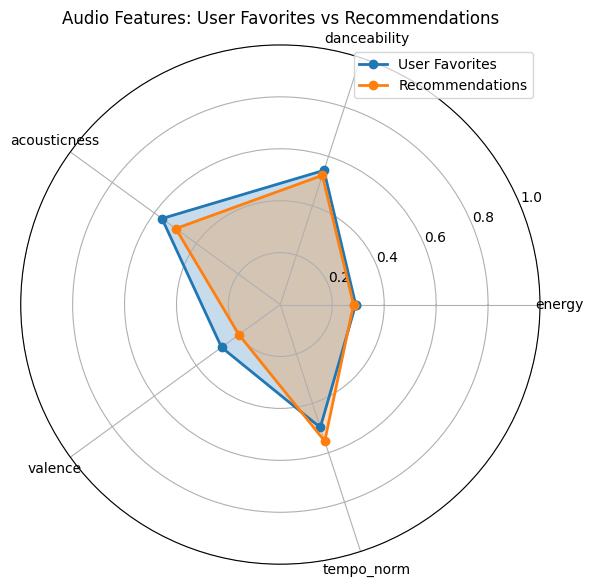

<Figure size 1200x600 with 0 Axes>

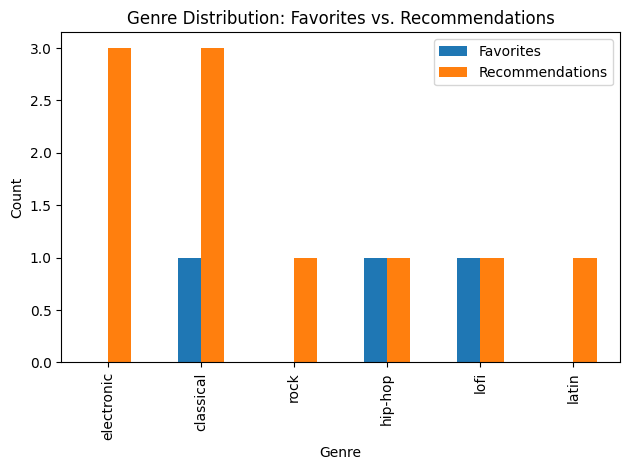

In [44]:
# Visualize the recommendations compared to user favorites
def visualize_recommendations(user_favorites, recommendations, all_songs):
    # Get user favorite songs
    favorite_songs = all_songs[all_songs['track_id'].isin(user_favorites)]
    
    # Selected features to compare
    features_to_compare = ['energy', 'danceability', 'acousticness', 'valence', 'tempo']
    
    # For better visualization, normalize tempo to [0,1] range
    favorite_songs_viz = favorite_songs.copy()
    recommendations_viz = recommendations.copy()
    
    # Check if all required columns are present
    for feature in features_to_compare:
        if feature not in favorite_songs.columns:
            print(f"Warning: {feature} not found in favorite_songs. Available columns: {favorite_songs.columns.tolist()}")
        if feature not in recommendations.columns:
            print(f"Warning: {feature} not found in recommendations. Available columns: {recommendations.columns.tolist()}")
    
    # Normalize tempo
    favorite_songs_viz['tempo_norm'] = favorite_songs['tempo'] / 200
    recommendations_viz['tempo_norm'] = recommendations['tempo'] / 200
    viz_features = [f if f != 'tempo' else 'tempo_norm' for f in features_to_compare]
    
    favorite_avg = favorite_songs_viz[viz_features].mean()
    recommendation_avg = recommendations_viz[viz_features].mean()
    
    # Radar chart
    labels = viz_features
    num_vars = len(labels)
    
    # Calculate angles for each feature
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    
    # Add values for both datasets
    favorite_values = favorite_avg.tolist()
    favorite_values += favorite_values[:1]
    
    recommendation_values = recommendation_avg.tolist()
    recommendation_values += recommendation_values[:1]
    
    # Create radar plot
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(polar=True))
    
    # Plot favorites
    ax.plot(angles, favorite_values, 'o-', linewidth=2, label='User Favorites')
    ax.fill(angles, favorite_values, alpha=0.25)
    
    # Plot recommendations
    ax.plot(angles, recommendation_values, 'o-', linewidth=2, label='Recommendations')
    ax.fill(angles, recommendation_values, alpha=0.25)
    
    # Set labels and adjust display
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right')
    
    plt.title('Audio Features: User Favorites vs Recommendations')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    # Count genres in favorites and recommendations
    favorite_genres = favorite_songs['playlist_genre'].value_counts().reindex(
        recommendations['playlist_genre'].value_counts().index, fill_value=0)
    recommended_genres = recommendations['playlist_genre'].value_counts()
    
    genre_comparison = pd.DataFrame({
        'Favorites': favorite_genres,
        'Recommendations': recommended_genres
    })
    
    genre_comparison.plot(kind='bar')
    plt.title('Genre Distribution: Favorites vs. Recommendations')
    plt.ylabel('Count')
    plt.xlabel('Genre')
    plt.tight_layout()
    plt.show()

# Visualize the example recommendations
visualize_recommendations(example_favorites, example_recommendations, spotify_data)